# Segmentation des clients du site 

- Commencer l'application des méthodes de clustering (K-means, Arbre hiérarchique ascendante (AHA), DB-scan ) 
- Estimer les valeurs optimales des hyperparamètres de chaque méthode via les métriques adéquates (critères de silhouette et de Davies-Bouldin pour K-means et AHA, K-Plus-Proches-Voisins pour DBscan).
- Appliquer les méthodes de clustering pour le dataframe avec les variables de catégories, avec les composantes principales représentant les variables de catégories
- Comparer les résultats des méthodes avec les trois dataframes 

In [1]:
#imports 
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax

import os
import datetime
import time
import random
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import sklearn.decomposition as decomposition
from scipy import stats
import scipy.cluster.hierarchy as shc

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score

from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv("./customers.csv", error_bad_lines=False, sep=',')


In [3]:
categories =  ['customer_unique_id',  'perfumery', 'art', 'sports_leisure',  'baby',   'housewares', 'musical_instruments',   'cool_stuff',  'furniture_decor',  'home_appliances',   'toys',   'bed_bath_table', 'construction_tools_safety',  'computers_accessories',    'health_beauty', 'luggage_accessories', 'garden_tools',    'office_furniture',   'auto',  'electronics',    'fashion_shoes', 'telephony',   'stationery',
  'fashion_bags_accessories', 'computers',   'home_construction',    'watches_gifts','construction_tools_construction',  'pet_shop',    'small_appliances', 'agro_industry_and_commerce', 'furniture_living_room', 'signaling_and_security',    'air_conditioning',   'consoles_games', 'books_general_interest',   'costruction_tools_tools','fashion_underwear_beach',  'fashion_male_clothing',
  'kitchen_dining_laundry_garden_furniture', 'industry_commerce_and_business',  'fixed_telephony', 'construction_tools_lights',  'books_technical',   'home_appliances_2',   'party_supplies',    'drinks', 'market_place',   'la_cuisine',  'costruction_tools_garden', 'fashio_female_clothing', 'home_confort',  'audio',   'food_drink',  'music',   'food', 'tablets_printing_image',   'books_imported', 
  'small_appliances_home_oven_and_coffee',    'fashion_sport',  'christmas_supplies', 'fashion_childrens_clothes', 'dvds_blu_ray',  'arts_and_craftmanship',   'furniture_bedroom',   'cine_photo', 'diapers_and_hygiene',   'flowers',   'home_comfort_2',  'security_and_services', 'furniture_mattress_and_upholstery',   'cds_dvds_musicals']
features =  ['customer_unique_id', 'Average_price', 'Total_prices', 'Nombre_commandes','Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume','Recency']

In [4]:
final_customer_dataframe = df[features]
most_bought_categories = df[categories]

In [5]:
#fonction de standardisation
def standardizer(df, scaler):
    if scaler=="StandardScaler" : 
        mms = StandardScaler()
    elif scaler=="MinMaxScaler" :
        mms = StandardScaler()
    
    df_copy = pd.DataFrame()
    nb_columns= df.shape[1]
    df_copy= df.iloc[: , 1: nb_columns]
    #select_dtypes('float64', 'int64')
    mms.fit(df_copy)
    df_transformed = mms.transform(df_copy)
    return df_transformed

In [6]:
final_customer_dataframe_transformed = standardizer(final_customer_dataframe, "StandardScaler")
df_sub_transformed = standardizer(final_customer_dataframe.head(50000), "StandardScaler")


In [7]:
#crée un sous ensemble random de données de taille l_size
def get_random_df (X, l_size):
    randomlist = np.random.randint(low=1, high=X.shape[0], size=l_size)
    return X.iloc[randomlist]

In [8]:
df_temp = get_random_df (final_customer_dataframe, 300)
df_temp.head()
X_db= standardizer(df_temp, "StandardScaler")

In [9]:
most_bought_transformed = standardizer(most_bought_categories, "StandardScaler")

In [10]:
#nous avons besoin des fichiers au niveau des comparaiosn des modèles
directory= "../data/"
df_product = pd.read_csv(directory+"olist_products_dataset.csv", error_bad_lines=False, sep=',')
df_cat_names = pd.read_csv(directory+"product_category_name_translation.csv", error_bad_lines=False, sep=',')
df_geo = pd.read_csv(directory+'olist_geolocation_dataset.csv', error_bad_lines=False, sep=',')
df_customer = pd.read_csv(directory+'olist_customers_dataset.csv', error_bad_lines=False, sep=',')
df_order_items= pd.read_csv(directory+"olist_order_items_dataset.csv", error_bad_lines=False, sep=',')
df_order_payment = pd.read_csv(directory+"olist_order_payments_dataset.csv", error_bad_lines=False, sep=',')
df_orders = pd.read_csv(directory+"olist_orders_dataset.csv", error_bad_lines=False, sep=',')
df_order_reviews = pd.read_csv(directory+"olist_order_reviews_dataset.csv", error_bad_lines=False, sep=',')
df_seller = pd.read_csv(directory+"olist_sellers_dataset.csv", error_bad_lines=False, sep=',')

df_file_list= [df_product, df_cat_names, df_geo , df_customer, df_order_items, df_order_payment , df_orders , df_order_reviews , df_seller ]


In [11]:
#dataframe avec les fetures créés et sans les catégories les plus achetées (réduit)
X= df_sub_transformed

In [12]:
#kmeans  elbow
def plot_elbow_kmeans(Sum_of_squared_distances, K): 
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [13]:
# Elbow Method for K means - Import ElbowVisualizer
def elbow_visualizer(X, model, mini, maxi):
    #model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(mini, maxi), timings= True)
    visualizer.fit(X)        # Fit data to visualizer
    visualizer.show()        # Finalize and render figure

In [14]:
# Silhouette Score for K means
def silhouette_score_visualisation (X, model):
    #model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= False)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

In [15]:
# Calinski Harabasz Score for K means
def Calinski_Harabasz_visualize(X, model):
    #model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz', timings= True)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show() 
    

In [16]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
def davies_bouldin_visualize(data, n_clusters):

    #instantiate kmeans
    kmeans = KMeans(n_clusters=n_clusters)
    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score

In [17]:
#k-means 
def kmeans_clustering(df, mini, maxi, model):
    Sum_of_squared_distances = []
    K = range(mini, maxi)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(X)
        Sum_of_squared_distances.append(km.inertia_)
    #elbow method
    #plot_elbow_kmeans(Sum_of_squared_distances,  range (mini, maxi))
    elbow_visualizer(X, model, mini, maxi)
    #silhouette 
    silhouette_score_visualisation (X, model)
    #calinski harabasz
    Calinski_Harabasz_visualize(X, model)
    #davies bouldin
    scores = []
    centers = list(range(2,30))
    for center in centers:
        scores.append(davies_bouldin_visualize(X, center))
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('Davies Bouldin score');
    plt.title('Davies Bouldin score % K');

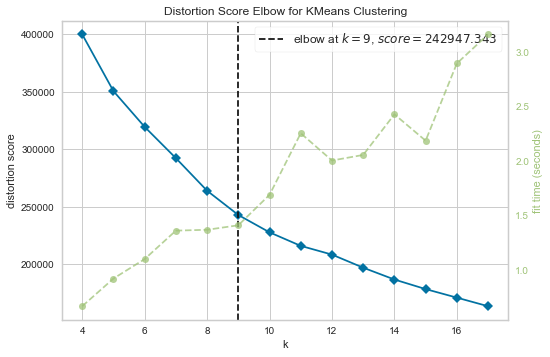

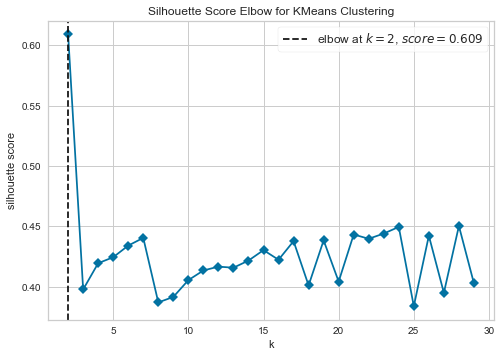

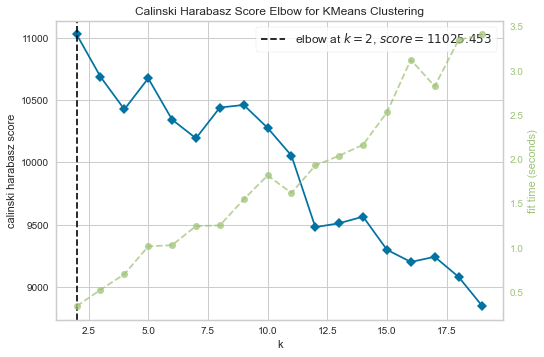

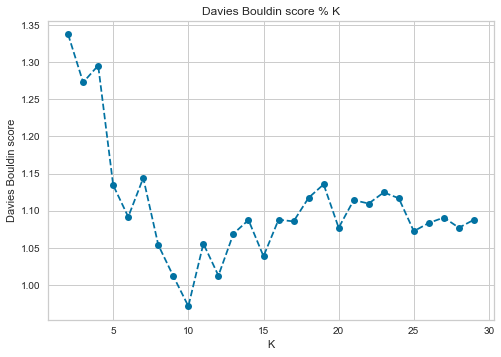

In [18]:
# k-means sur les données non standardisés 
model = KMeans()
mini= 4
maxi= 18
kmeans_clustering(X, mini, maxi, model)

- Sur des données non standardisés et avec la méthode Elbow, il est difficile dans ce cas de détecter le nombre de cluster K nous allons standardiser nos données et faire recours à d'autres méthodes

- Il est difficile de détecter la valeur de K visuellement dans ce cas, donc nous allons nous baser sur les scores

- à travers le score Calisnki Harabasz, nous pouvons déduire que le nombre de cluster K est autour de 7  

- Le critère de Davies Bouldin score est minimal pour K=8
- Le silhouette Score est maximal pour un k = 12
- Le critère Calinski Harabasz est maximal pour k = 15

- Donc on ne peut pas trancher pour la valeur de K directement, nous allons creuser encore le critère Silhouette score


In [19]:
def Initialize_model(X, n_clusters, model_name):
    if model_name == "KM":
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
    elif model_name == "HC" :
        clusterer = AgglomerativeClustering(distance_threshold=0,n_clusters=None, affinity='euclidean', linkage='ward')
        cluster_labels = model.fit_predict(X)
    return clusterer, cluster_labels

In [20]:

def plot_silhouette_k(X, model_name):
    
    range_n_clusters = [6, 8, 10, 11, 12, 13]

    for n_clusters in range_n_clusters:
        clusterer, cluster_labels = Initialize_model(X, n_clusters, model_name)
        
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(20, 10)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 6 The average silhouette_score is : 0.43433824465684084
For n_clusters = 8 The average silhouette_score is : 0.3870681070292614
For n_clusters = 10 The average silhouette_score is : 0.404770585235412
For n_clusters = 11 The average silhouette_score is : 0.4128721003409225
For n_clusters = 12 The average silhouette_score is : 0.41532076465794887
For n_clusters = 13 The average silhouette_score is : 0.4223921480507046


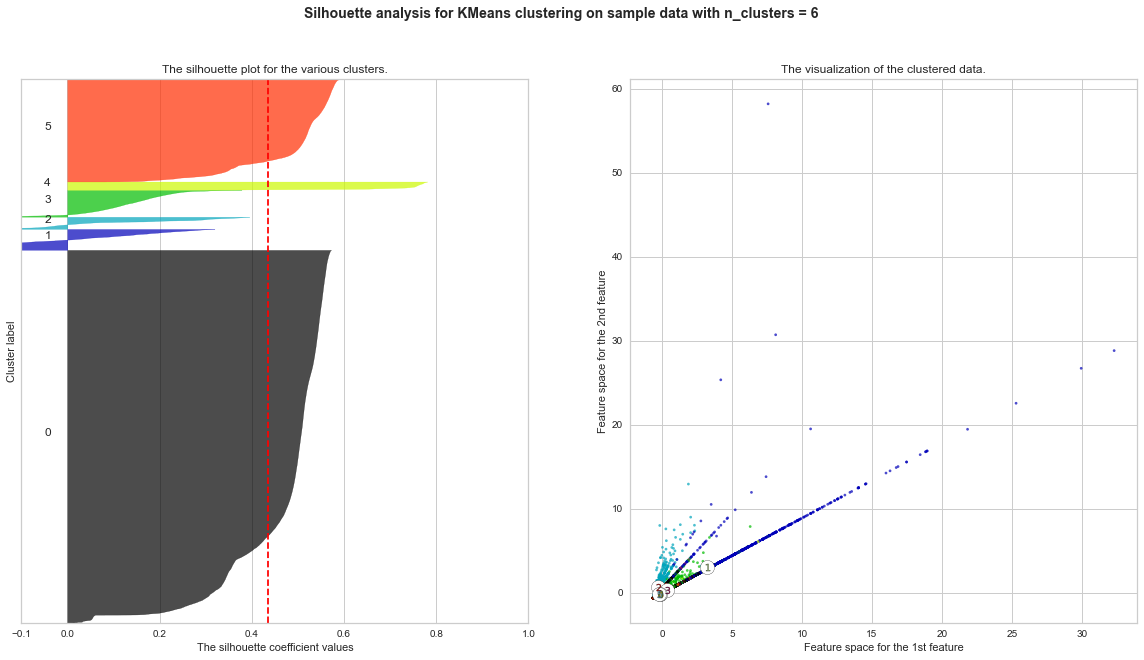

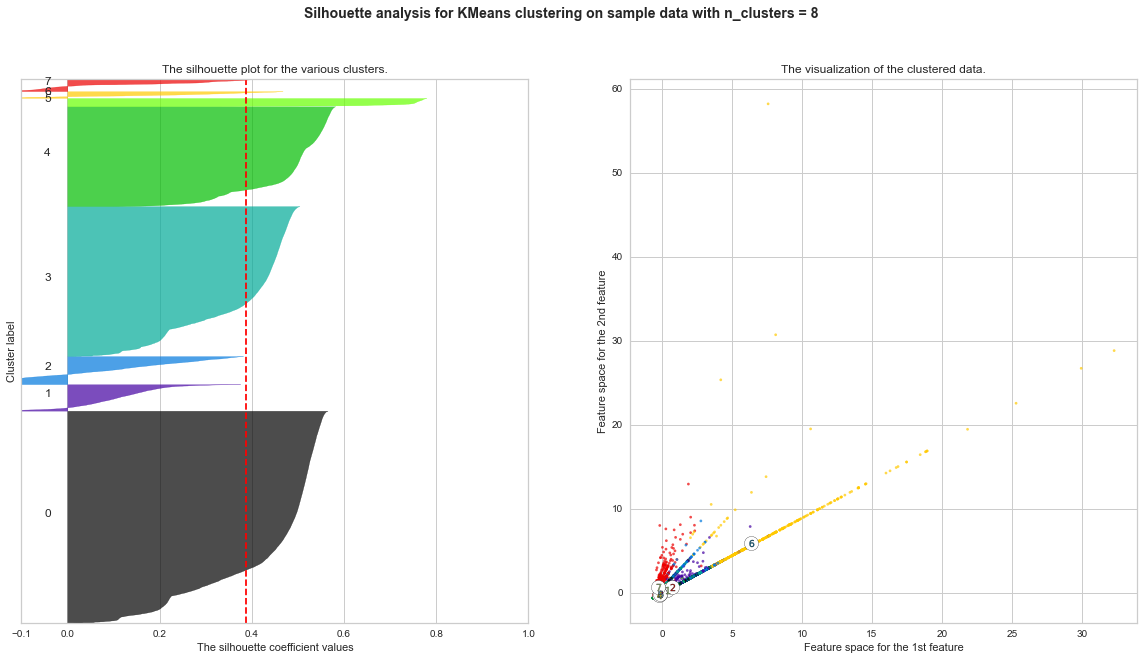

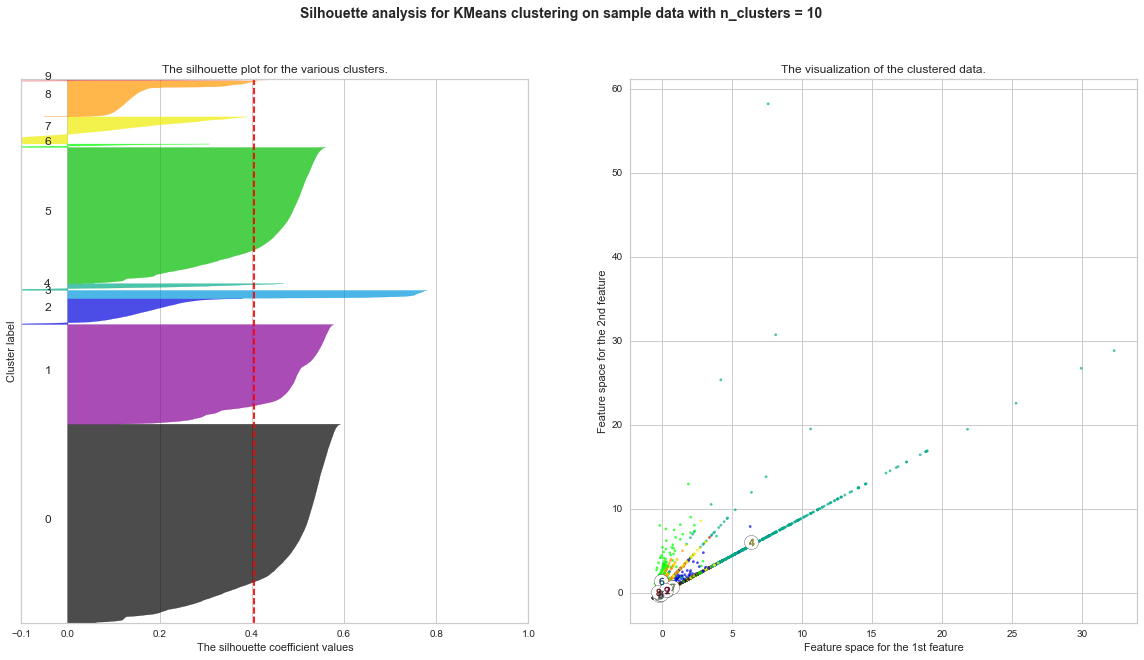

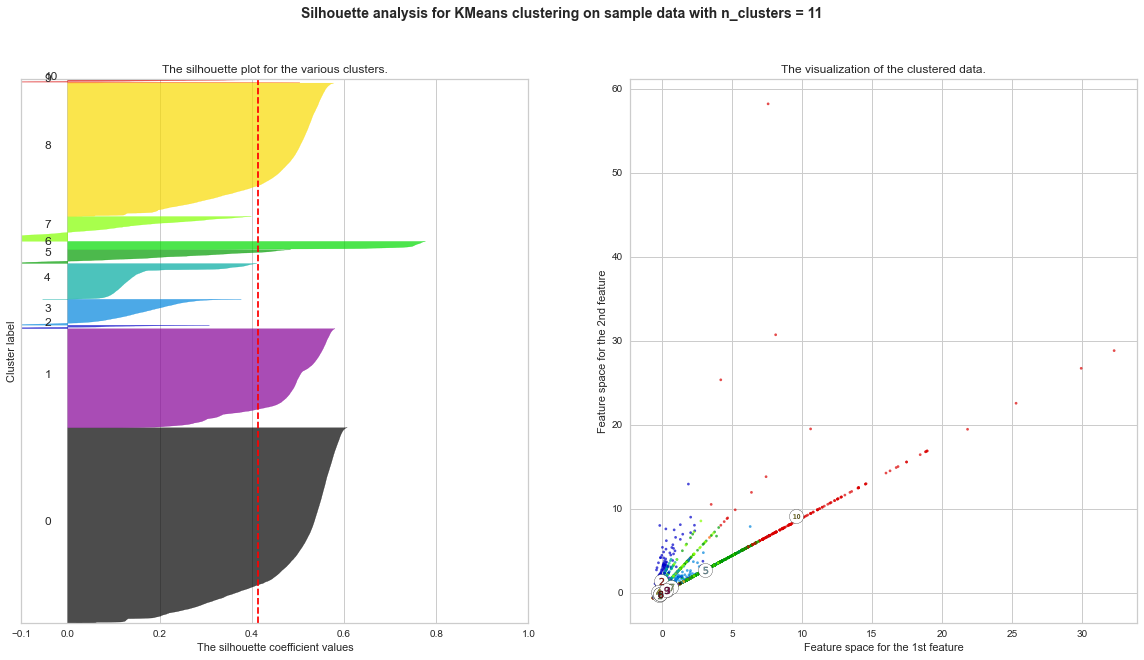

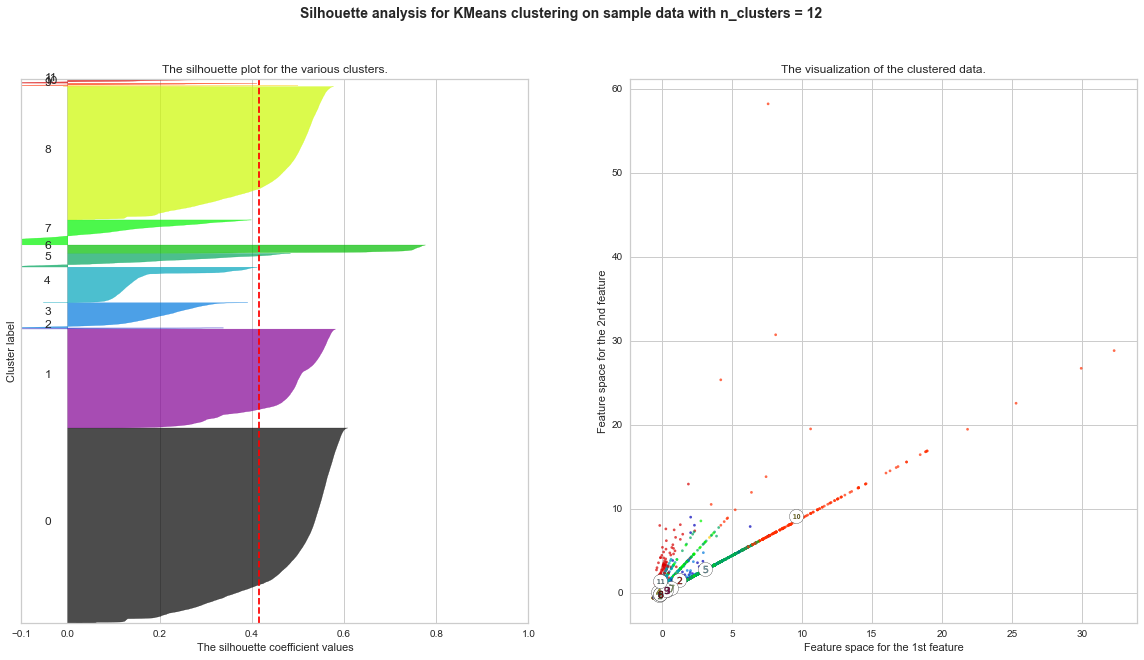

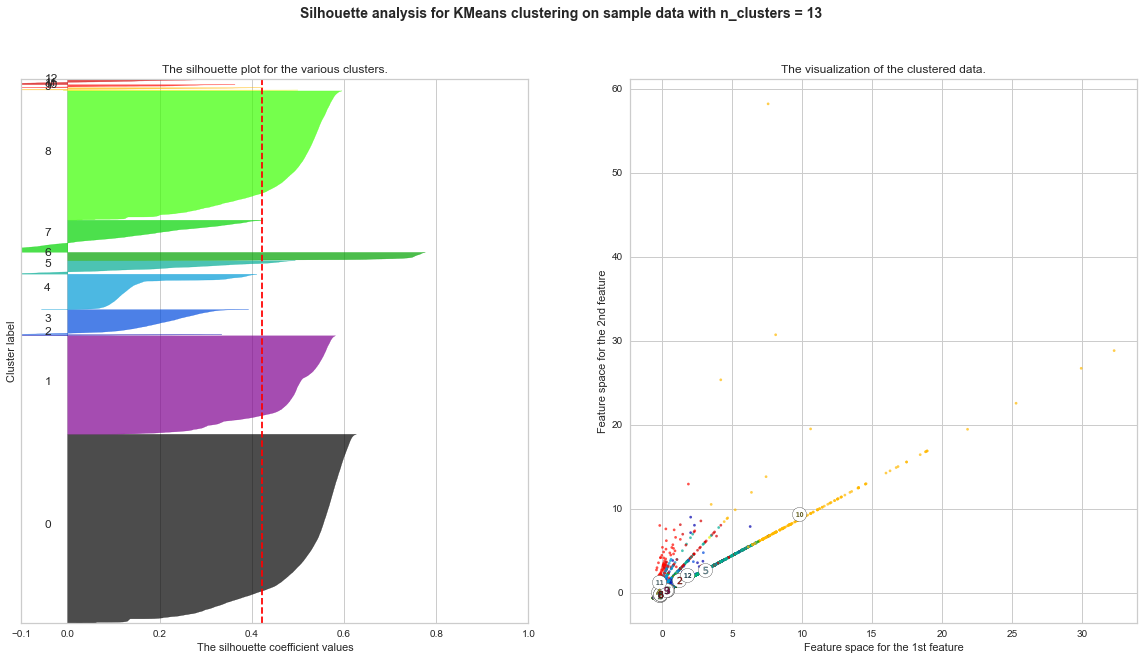

In [21]:
plot_silhouette_k(X, "KM")

- La comparaison de distribution / équilibre des cluster ainsi que la meilleure valeur de silhouette score nous permet de trancher plus facilement par rapport au nombre de cluster et leur équilibre de distribution

In [22]:
def tsne_kmeans(n_clusters, X, n_components): 

    kmeans = KMeans(n_clusters=n_clusters)
    clustering_ori = kmeans.fit_predict(X)

    Xtsne = TSNE(n_components=n_components).fit_transform(X)
    dftsne = pd.DataFrame(Xtsne)

    dftsne['cluster'] = clustering_ori
    dftsne.columns = ['x1','x2','cluster']

    plt.figure(figsize=(10,10))
    plt.title('Représentation des clusters (k-means) avec  T-SNE')
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster', legend='full',
                   palette=sns.color_palette("hls",n_clusters))
    plt.legend(loc='upper left', labels=dftsne['cluster'].unique())
    plt.show()

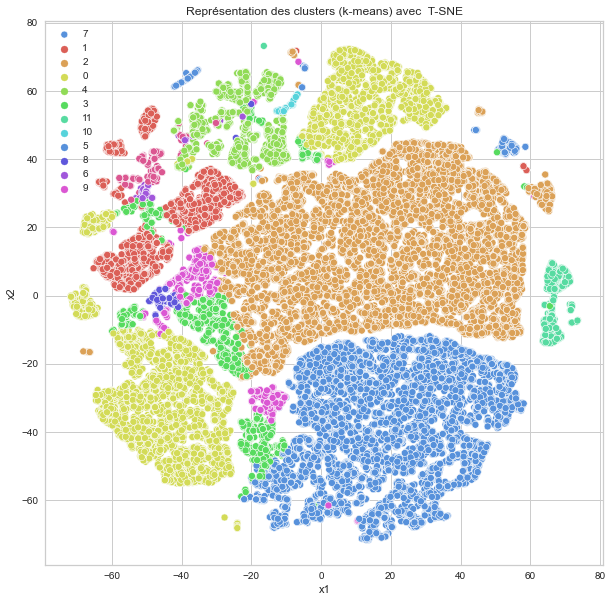

In [23]:
n_clusters= 12
n_components= 2
tsne_kmeans(n_clusters, X, n_components)

## Hierarchical clustering

In [24]:
# Dendogram for Heirarchical Clustering
def plot_dendrogram(model): 
    plt.figure(figsize=(15, 12))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(X, method='ward'))
    distances = model.distances_
    return distances 

In [25]:
# Silhouette Score for K means
def silhouette_score_visualisation_Hierarchical (X):
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= False)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure



In [26]:
# Elbow Method for K means - Import ElbowVisualizer
def elbow_visualizer_h(X, mini, maxi):
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(mini, maxi), timings= True)
    visualizer.fit(X)        # Fit data to visualizer
    visualizer.show()        # Finalize and render figure

In [27]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
def davies_bouldin_visualize_Hierarchical(data, n_clusters):
    #instantiate kmeans
    hc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    # Then fit the model to your data using the fit method
    model = hc.fit_predict(data)
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)  
    return score

In [28]:
def hierarchical_clustering(X):
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
    model = model.fit(X)
    distances  = plot_dendrogram(model)
    distances

In [29]:
def hierarchical_clustering_scores(X, mini, maxi):
    hierarchical_clustering(X)
    #elbow method 
    elbow_visualizer_h(X, mini, maxi)
    #silhouette score
    silhouette_score_visualisation_Hierarchical (X)
    #davies bouldin
    scores = []
    centers = list(range(mini, maxi))
    for center in centers:
        scores.append(davies_bouldin_visualize_Hierarchical(X, center))
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('Davies Bouldin score');
    plt.title('Davies Bouldin score % K');

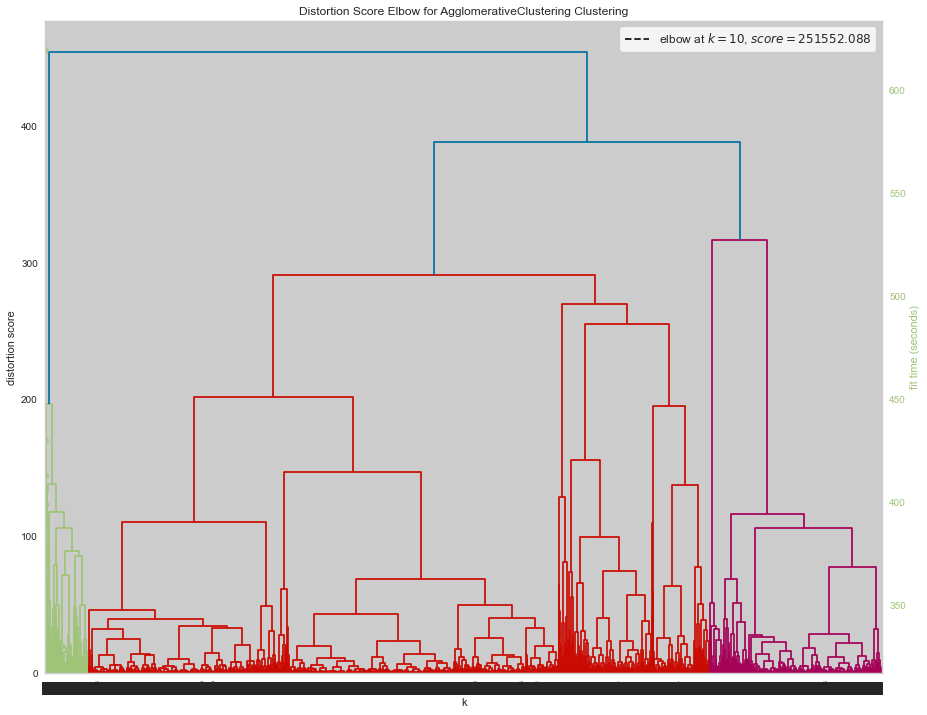

KeyboardInterrupt: 

In [30]:
mini = 5
maxi = 17
hierarchical_clustering_scores(X, mini, maxi)

**Les résultats obtenus montrent un maximum absolu pour k =8  pour le critère de silhouette et un minimum absolu autour de k =8 pour le critère de Davies Bouldin**
--> Nombre de cluster k : 8 

In [31]:
def scatter_hierarchical(X, n_clusters, n_components):

    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster= model.fit_predict(X)
    Xtsne = TSNE(n_components=n_components).fit_transform(X)
    dftsne = pd.DataFrame(Xtsne)

    dftsne['cluster'] = cluster
    dftsne.columns = ['x1','x2','cluster']

    plt.figure(figsize=(10,10))
    plt.title('Représentation des clusters (Arbre hierarchique) avec  T-SNE')
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster', legend='full',
                   palette=sns.color_palette("hls",n_clusters))
    plt.legend(loc='upper left', labels=dftsne['cluster'].unique())
    plt.show()
    


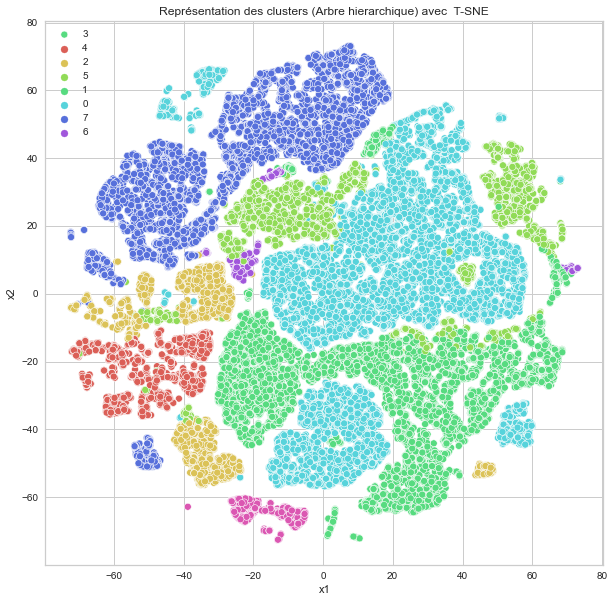

In [32]:
n_clusters= 8
n_components=2
scatter_hierarchical(X, n_clusters, n_components)

## DBScan

In [33]:
def nearest_neighbour_for_dbscan(n_neighbors, X):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.figure(figsize=(14,7))
    plt.title('K-distance Graph',fontsize=10)
    plt.xlabel('Data Points sorted by distance',fontsize=8)
    plt.ylabel('Epsilon',fontsize=8)
    plt.plot(distances)
    plt.show()

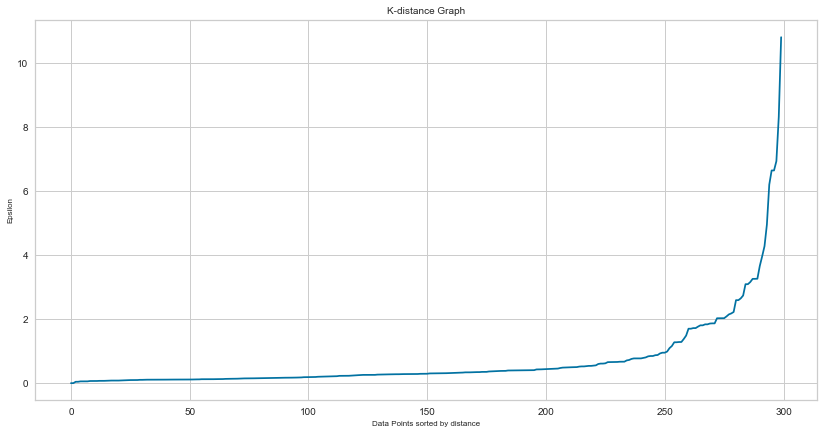

In [34]:
n_neighbors=5
nearest_neighbour_for_dbscan(n_neighbors, X_db)

- On va sélectionner à partir du graphique une valeur de eps = 2.3 et le paramètre min_pts ~ 2* nombre de features alors 28

In [35]:
# DBSCAN
def DBScan_clustering(eps, min_samples, X): 
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
    return labels , core_samples_mask, n_clusters_

In [36]:
eps = 2.8
min_pts = 24

- déduction par rapport aux paramètres eps et min_points

In [37]:
def plot_dbscan_clusters (labels, X, core_samples_mask):
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters)
    plt.show()

In [38]:
#fixation des meilleurs hyperparamètre et visualisation via t-SNE
def tsne_dbscan(X, n_components, eps, min_samples):

    db = DBSCAN(eps=eps, min_samples=min_samples)
    cluster= db.fit_predict(X)
    Xtsne = TSNE(n_components=n_components).fit_transform(X)
    dftsne = pd.DataFrame(Xtsne)

    dftsne['cluster'] = cluster
    dftsne.columns = ['x1','x2','cluster']

    plt.figure(figsize=(10,10))
    plt.title('Représentation des clusters (Arbre hierarchique) avec  T-SNE')
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster', legend='full',
                   palette=sns.color_palette("hls",dftsne['cluster'].unique().shape[0]))
    plt.legend(loc='upper left', labels=dftsne['cluster'].unique())
    plt.show()
    


In [ ]:
labels, core_samples_mask, n_clusters_ = DBScan_clustering(eps, min_pts, X) 
#plot_dbscan_clusters (labels, X, core_samples_mask)

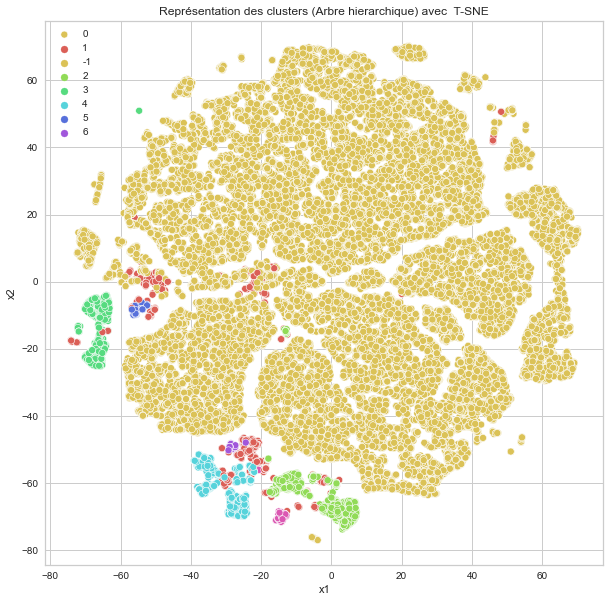

In [39]:
#Déduction du meilleur algorithme et les hyperparamètres optimaux de cet algorithme
tsne_dbscan(X, n_components, eps, min_pts)

## Reprise du pipeline avec les données des catégories (avec et sans réduction de dimentionnalité)

In [40]:
def transform_files(df_product, df_cat_names, df_geo , df_customer, df_order_items, df_order_payment , df_orders , df_order_reviews , df_seller):
    df_product = pd.merge(df_product, df_cat_names, on=['product_category_name'], how='left')
    df_product= df_product.drop_duplicates()
    categories = df_product['product_category_name_english'].unique()
    df_product= df_product.drop('product_category_name', axis=1)
    df_product = df_product.rename(columns={'product_category_name_english': 'product_category_name'})
    df_file_list= [df_product, df_cat_names, df_geo , df_customer, df_order_items, df_order_payment , df_orders , df_order_reviews , df_seller ]
    return df_file_list

In [41]:
#initialisation du dataframe avec l'id et l'unique id de client
def initialize_dataframe(df_customer_copy):
    final_customer_dataframe = pd.DataFrame()
    #construire le nouveau dataframe en effectuant des transformations progressives sur les variables 
    final_customer_dataframe ['customer_id']= df_customer_copy['customer_id']
    final_customer_dataframe ['customer_unique_id']= df_customer_copy['customer_unique_id']
    final_customer_dataframe['customer_zip_code_prefix']= df_customer_copy['customer_zip_code_prefix']
    return final_customer_dataframe
#extraction d'informations relatives aux produits achetés et sommes dépensées 
def product_information_add(df_customer_copy, df_order_items_copy, df_orders_copy):
    #Nombre de produits achetés par client
    produits_par_client = pd.merge(df_customer_copy, 
                           pd.merge(df_order_items_copy, 
                                    df_orders_copy, how="left" , on ="order_id"), how="left", on="customer_id")
    produits_par_client = produits_par_client.drop_duplicates()
    produits_par_client['Total_produits_achete'] = produits_par_client.groupby('customer_id')['order_item_id'].transform('count')
    #Nombre de commande par utilisateur (frequence)
    produits_par_client['Nombre_commandes'] = produits_par_client.groupby('customer_id')['order_id'].transform('count')
    #Montant moyen d'achat par commande par utilisateur
    produits_par_client['Total_prices'] = produits_par_client.groupby('customer_id')['price'].transform('sum')
    produits_par_client['Average_price'] = produits_par_client['Total_prices'] /produits_par_client['Nombre_commandes']
    #Montant max d'achat par commande par utilisateur
    produits_par_client["Max_price"] = produits_par_client.groupby('customer_id')['Total_prices'].transform(max)
    #merge avec dataframe final
    produits = produits_par_client[['customer_id', 'Max_price', 'Average_price', 'Total_prices',  'Nombre_commandes', 'Total_produits_achete']]
    return  produits_par_client
#extraction d'informations relatives aux revies et scores
def review_information_add(df_customer_copy, df_order_reviews, df_orders_copy):
    #Personne qui commente/ note/ ne réagit pas 
    reviews_par_client = pd.merge(df_customer_copy, 
                           pd.merge(df_order_reviews, 
                                    df_orders_copy, how="left" , on ="order_id"), how="left", on="customer_id")
    reviews_par_client = reviews_par_client.drop_duplicates()
    reviews_par_client['gives_score'] = reviews_par_client.groupby("customer_id")['review_score'].transform('count')
    reviews_par_client['makes_review'] = reviews_par_client.groupby("customer_id")['review_comment_message'].transform('count')
    reviews = reviews_par_client[['customer_id', 'gives_score', 'makes_review']]
    return reviews

#extraction d'informations relatives aux characteristiques de produits (categories, volumes et poids)
def product_characteristics_add(df_customer_copy, produits_par_client, df_product_copy):
    categories = df_product_copy['product_category_name'].unique()
    cat= ['customer_id']
    for e in categories :
        cat.append(e)
     #Poids moyens de commandes 
    product_catacteristics = pd.merge(produits_par_client, df_product_copy, how="left" , on ="product_id")
    
    product_catacteristics = product_catacteristics.drop_duplicates()
    product_catacteristics['Total_weight'] = product_catacteristics.groupby('customer_id')['product_weight_g'].transform('sum')
    product_catacteristics['Mean_weight'] = product_catacteristics['Total_weight']/product_catacteristics ['Nombre_commandes']
    #Poids maximum de commandes   
    df_temp_grouped = product_catacteristics.groupby(['customer_id', 'order_id'])
    product_catacteristics['Max_weight'] = product_catacteristics.groupby(['customer_id', 'order_id'])['product_weight_g'].transform('sum').max()
    #Volume moyen des commandes 
    product_catacteristics['item_volume'] = product_catacteristics['product_length_cm']*product_catacteristics['product_height_cm']*product_catacteristics['product_width_cm']
    product_catacteristics['order_volume'] = product_catacteristics.groupby(['customer_id', 'order_id'])['item_volume'].transform("sum")
    product_catacteristics['Mean_Volume'] = product_catacteristics.groupby(['order_id'])['order_volume'].transform('mean')
    #les categories et leurs fréquences
    #grouped_caracteristics = product_catacteristics.groupby(['customer_id', 'order_id'])
    
    #print(product_catacteristics.head())
    characteristics= product_catacteristics[['customer_id',  'Mean_weight',  'Mean_Volume']]
    #print(characteristics.head())
    for product_category in categories :
        df_temp = product_catacteristics[product_catacteristics['product_category_name'] == product_category]
        #print(product_category)
        product_catacteristics[product_category]= df_temp.groupby('customer_id')['order_item_id'].transform('count')
    #print(product_catacteristics.columns)
    df_categories = pd.DataFrame()
    df_categories = product_catacteristics[cat]
    most_bought_categories = df_categories.copy()
    most_bought_categories = pd.merge(most_bought_categories, df_customer_copy, how ="left", on ="customer_id")
    most_bought_categories = most_bought_categories.drop_duplicates()
    new_cat = ['customer_unique_id']
    for c in categories :
        new_cat.append(c)
    most_bought_categories = most_bought_categories[new_cat]
    return characteristics, most_bought_categories

#extraction d'informations relatives à la récence des commandes
def get_recency_info(df_customer_copy, df_orders_copy) : 
    dateTimeObj = datetime.datetime.now().toordinal()
    orders_par_client = pd.merge(df_customer_copy, df_orders_copy, how="left" , on ="customer_id")
    orders_par_client = orders_par_client.drop_duplicates()
    orders_par_client['order_purchase_timestamp']= orders_par_client['order_purchase_timestamp'].apply(lambda x: pd.to_datetime(x).toordinal() if pd.notna(x) else 0)
    #(orders_par_client['order_purchase_timestamp'].values)
    grouped_orders= orders_par_client.groupby('customer_id')
    orders_par_client['Recency'] = dateTimeObj - orders_par_client['order_purchase_timestamp']
    orders = orders_par_client[['customer_id', 'Recency']] 
    return orders
#extraction d'informations relatives aux modes de payements utilisés
def payment_information_add(df_customer_copy, df_order_payment_copy, df_orders_copy):
    #Moyens de payement utilisés et fréquence d'utilisation
    payment_par_client = pd.merge(df_customer_copy, 
                           pd.merge(df_order_payment_copy, 
                                    df_orders_copy, how="left" , on ="order_id"), how="left", on="customer_id")
    payment_par_client = payment_par_client.drop_duplicates()
    payment_types = ['credit_card', 'debit_card', 'boleto', 'voucher', 'not_defined']
    for i in range(0, len(payment_types)) : 
        df_payment_type = pd.DataFrame()
        df_payment_type = payment_par_client[payment_par_client['payment_type'] == payment_types[i]]
        grouped_payments = df_payment_type.groupby('customer_id')
        payment_par_client[payment_types[i]]= grouped_payments['payment_type'].transform('count')
    payment = payment_par_client[['customer_id', 'credit_card', 'debit_card', 'boleto', 'voucher']]
    #payment = payment_par_client[["customer_id", 'card', 'other']]
    return payment

#corrections à appliquer au dataframe avant exploitataion 
def refine_dataframe(df):
    df = df.groupby(['customer_unique_id']).sum()
    df = df.fillna(0)
    #df = df.drop('customer_id', axis=1)
    df = df.drop('customer_zip_code_prefix', axis=1)
    #df = df.drop_duplicates(subset='customer_unique_id', keep="first")
    return df
#fonction rassemblant les différents traitements cités et générant 
#les features et info de catégorie
def transform_features(df_file_list, add_cat):
   
    most_bought_categories =  pd.DataFrame()
    #create data copies
    df_product_copy = df_file_list[0].copy()
    df_cat_names_copy= df_file_list[1].copy()
    df_geo_copy= df_file_list[2].copy()
    df_customer_copy= df_file_list[3].copy()
    df_order_items_copy= df_file_list[4].copy()
    df_order_payment_copy= df_file_list[5].copy()
    df_orders_copy= df_file_list[6].copy()
    df_order_reviews_copy= df_file_list[7].copy()
    df_seller_copy = df_file_list[8].copy()
    
    #transform features
    final_customer_dataframe = initialize_dataframe(df_customer_copy)
    produits_par_client= product_information_add(df_customer_copy, df_order_items_copy, df_orders_copy)
    produits = produits_par_client[['customer_id', 'Average_price', 'Total_prices',  'Nombre_commandes', 'Total_produits_achete']] 
    reviews = review_information_add(df_customer_copy, df_order_reviews, df_orders_copy)
    characteristics, most_bought_categories = product_characteristics_add(df_customer_copy, produits_par_client, df_product_copy)
    orders = get_recency_info(df_customer_copy, df_orders_copy)
    payment =  payment_information_add(df_customer_copy, df_order_payment_copy, df_orders_copy)
    
    # final dataframe 
    final_customer_dataframe=  pd.merge(final_customer_dataframe, produits, how="left", on="customer_id") 
    final_customer_dataframe = final_customer_dataframe.drop_duplicates()
    print(final_customer_dataframe.columns)
    final_customer_dataframe=  pd.merge(final_customer_dataframe, reviews, how="left", on="customer_id") 
    final_customer_dataframe = final_customer_dataframe.drop_duplicates()
    print(final_customer_dataframe.columns)
    final_customer_dataframe=  pd.merge(final_customer_dataframe, payment, how="left", on="customer_id") 
    final_customer_dataframe = final_customer_dataframe.drop_duplicates()
    print(final_customer_dataframe.columns)
    final_customer_dataframe=  pd.merge(final_customer_dataframe, characteristics, how="left", on="customer_id") 
    final_customer_dataframe = final_customer_dataframe.drop_duplicates()
    print(final_customer_dataframe.columns)
    final_customer_dataframe = pd.merge(final_customer_dataframe, orders, how="left", on="customer_id") 
    final_customer_dataframe = final_customer_dataframe.drop_duplicates()
    final_customer_dataframe = refine_dataframe(final_customer_dataframe)
    if add_cat :
        final_customer_dataframe = pd.merge(final_customer_dataframe, most_bought_categories, how="left", on="customer_unique_id") 
        final_customer_dataframe = final_customer_dataframe.drop_duplicates()
    
    print(final_customer_dataframe.shape)
    return final_customer_dataframe, most_bought_categories

In [42]:
final_customer_dataframe_categories = pd.DataFrame()
df_file_list = transform_files(df_product, df_cat_names, df_geo , df_customer, df_order_items, df_order_payment , df_orders , df_order_reviews , df_seller)
final_customer_dataframe_categories, most_bought_categories = transform_features(df_file_list, True)


Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='object')
(98967, 86)


In [43]:
final_customer_dataframe_categories = final_customer_dataframe_categories.fillna(0)

In [44]:
X_categories= standardizer(final_customer_dataframe_categories.head(50000), "StandardScaler")

### ACP application sur les categories 

In [45]:
def display_corr_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(12,12))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_fact_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,12))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, edgecolor='k')
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scre_plot(pca):
    scree = pca.explained_variance_ratio_*100
    fig = plt.figure(figsize=(12,12))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)


In [46]:
from sklearn.decomposition import PCA
#Réaliser une analyse en composante principale 
def principal_component_analysis(df):
    # choix du nombre de composantes à calculer
    n_comp =72
    # Centrage et Réduction
    X_scaled = standardizer(df, "StandardScaler")
    #names = df["nutriscore_grade"].unique() # ou data.index pour avoir les intitulés
    features = df.columns
    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)
    acp_df_generated = pd.DataFrame(pca.components_)
    
    # Eboulis des valeurs propres
    display_scre_plot(pca)
    
    # Cercle des corrélations
    pcs = pca.components_ 
    #display_corr_circles(pcs, n_comp, pca, [(0,1),(2,3), (1,2), (0,3)], labels = np.array(features))

    # Transform the original scaled data to the new vector space and display data points
    X_projected = pca.transform(X_scaled)
    #display_fact_planes(X_projected, n_comp, pca, [(0,1)],  alpha = 0.8)
    #display_fact_planes(X_projected, n_comp, pca, [(2,3)],  alpha = 0.8)
    #display_fact_planes(X_projected, n_comp, pca, [(4,5)],  alpha = 0.8)
    #display_fact_planes(X_projected, n_comp, pca, [(6,7)],  alpha = 0.8)
    X_projected = pca.transform(X_scaled)
    #display_fact_planes(X_projected, n_comp, pca, [(0,1),(2,3)])

    #plt.show()
    return acp_df_generated




In [47]:
most_bought_categories= most_bought_categories.fillna(0)

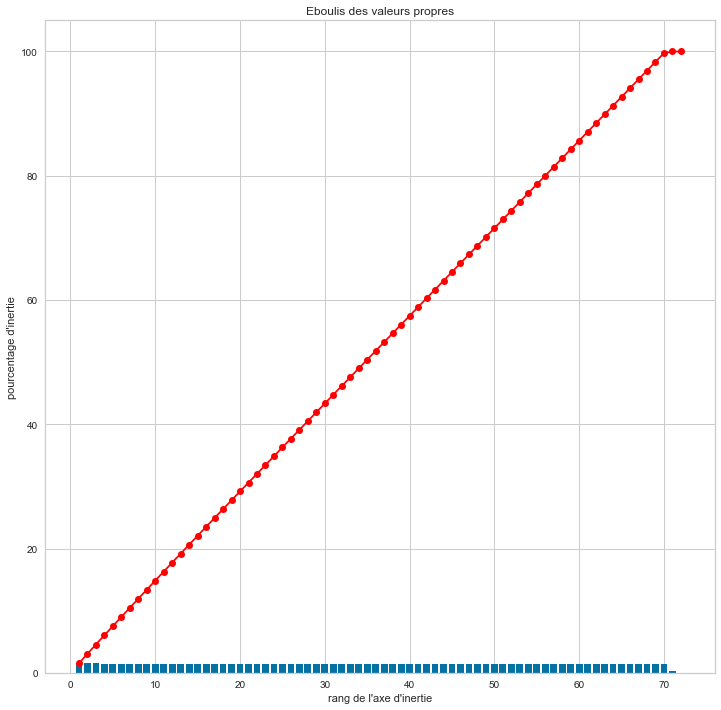

In [48]:
acp_df_g= principal_component_analysis(most_bought_categories)

In [49]:
clustering_results  = pd.DataFrame()
#fonction qui rajoute les k nombre de cluster et le modele
def add_to_results(results, model_name, k):
    results = results.append(pd.DataFrame({
    'Model_name' : [model_name], 
    'Cluster_number_k' : [k]
    }), ignore_index=True)
    return results


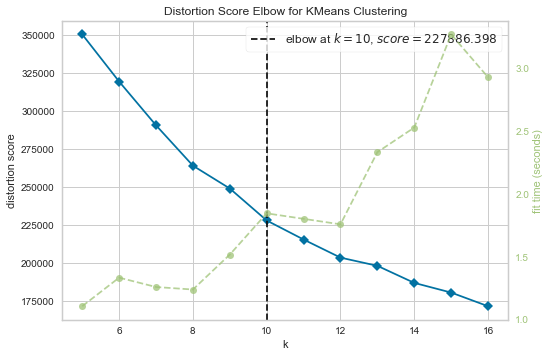

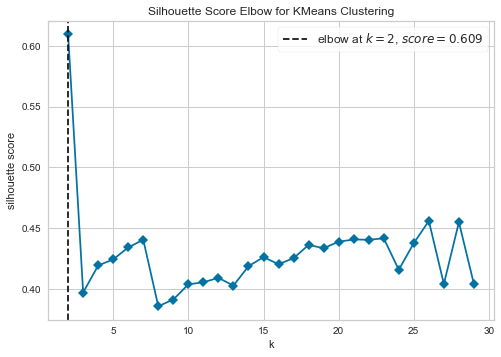

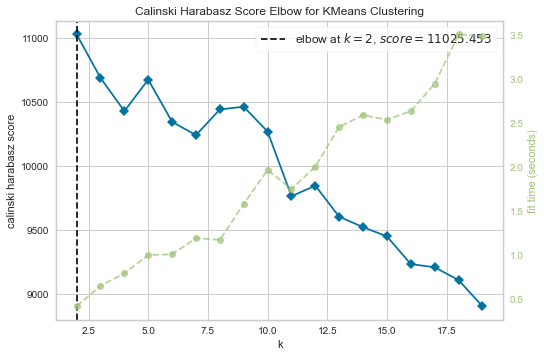

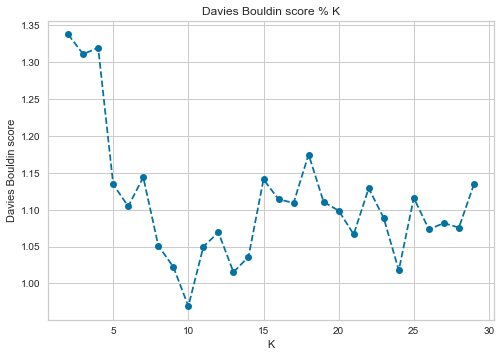

In [50]:
kmeans_clustering(X_categories, mini, maxi, model)

- Le meilleur résultat du silhouette score est obtenu pour k = 28 , le deuxième max est pour k = 23 et le troisième pour k =13. Nous retenons le k = 13 
- Le minimum du score de Davies Bouldin est obtenu pour un k = 13 
- Donc nous fixons k à 13

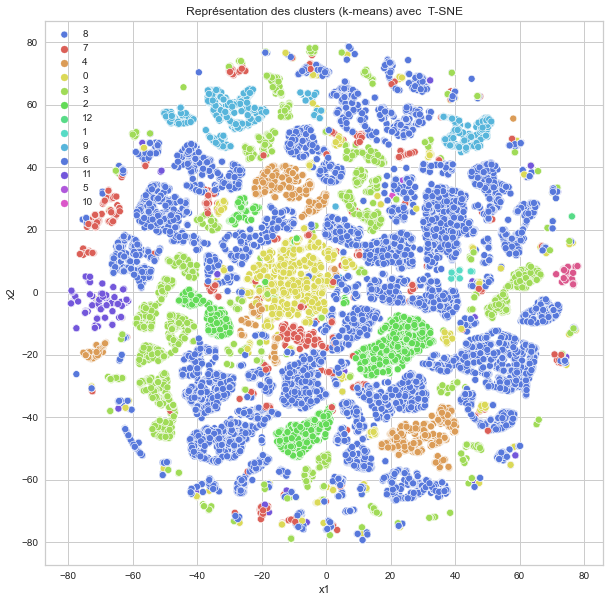

In [51]:
n_clusters= 13
n_components= 2
tsne_kmeans(n_clusters, X_categories, n_components)

In [ ]:
#hierarchical_clustering_scores(X_categories, mini, maxi)

In [ ]:
scatter_hierarchical(X_categories, n_clusters, n_components)

- Le meilleur silhouette score est obtenu pour une valeur de nombre de clusters k = 18 
- Le score de davies bouldin minimal est obtenu pour k = 18
- Donc le nombre de cluster k pour l'arbre hierarchique ascendante ets 19


In [53]:
df_t = get_random_df (final_customer_dataframe_categories, 300)
X_dbc= standardizer(df_t, "StandardScaler")

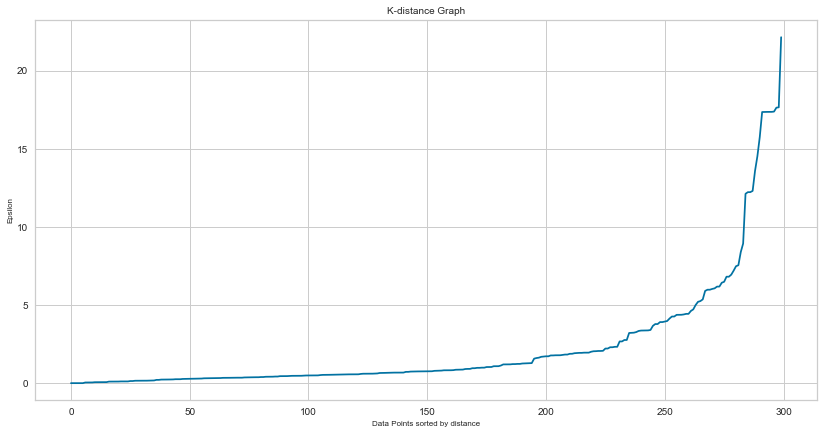

In [54]:
n_neighbors= 5
nearest_neighbour_for_dbscan(n_neighbors, X_dbc)

In [56]:
#deduce hyperparameter eps 
eps_c =5
minpts_c = final_customer_dataframe_categories.shape[1]*2


In [ ]:
DBScan_clustering(eps, minpts_c, X_categories)

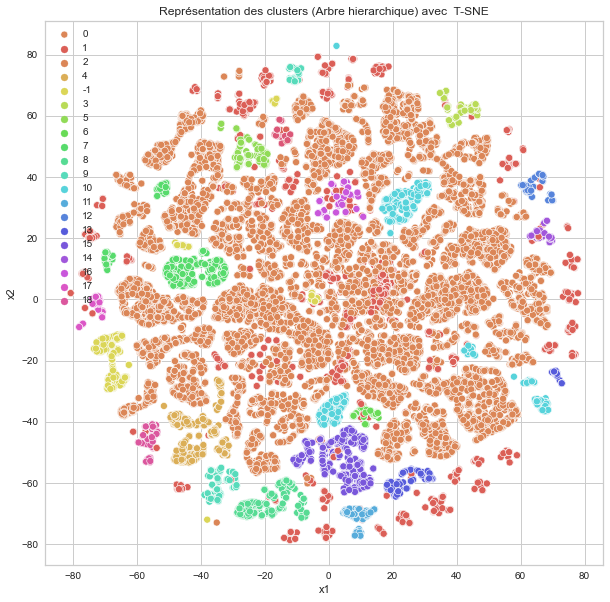

In [57]:
tsne_dbscan(X_categories, n_components, eps_c, minpts_c)

In [ ]:
#labels , core_samples_mask, n_clusters_ = DBScan_clustering(eps, min_pts, X_categories) 

In [58]:
km= 13
#add the scores to the result dataframe
clustering_results =add_to_results (clustering_results, "K-means", km)


In [59]:
kh= 18
#add the scores to the result dataframe
clustering_results =add_to_results (clustering_results, "Hierarchical", kh)

In [60]:
kd= 21
#add the scores to the result dataframe
clustering_results =add_to_results (clustering_results, "DBScan", kd)

In [61]:
clustering_results

,Model_name,Cluster_number_k
0,K-means,13
1,Hierarchical,18
2,DBScan,21


-  En conclusion le cluestring sur le dataframe avec les variables représentant les catégories est loin de donner des résultats satisfaisant dans la mesure où le nombre de cluster (bien que homogène sans trop de décalages entre les trois méthodes ) mais très important donc non interprétable 

## Comparaison des modèles
- series temporelles de rand ajustés sur les périodes ayant des dates de début espacées de 1 mois sur 6 mois avec des données de 1000 clients et l'algorithme sélectionné avec les hyperparamètres optimaux


In [62]:
def remove_after_date(df_file_list, list_customers_id, end_date, length):
    #create data copies
    print(end_date)
    print("start remove after date from dataframe")
    df_product_copy = df_file_list[0].copy()
    df_cat_names_copy= df_file_list[1].copy()
    df_geo_copy= df_file_list[2].copy()
    df_customer_copy= df_file_list[3].copy()
    df_order_items_copy= df_file_list[4].copy()
    df_order_payment_copy= df_file_list[5].copy()
    df_orders_copy= df_file_list[6].copy()
    df_order_reviews_copy= df_file_list[7].copy()
    df_seller_copy = df_file_list[8].copy()
    print(df_orders_copy.head(2))
    print(df_orders_copy.shape)
    
    print(df_orders_copy.head(2))
    print(len(list_customers_id))
    df_orders_copy = pd.merge(df_orders_copy, df_customer_copy, how="left", on="customer_id")
    df_orders_copy = df_orders_copy.loc [df_orders_copy.apply(lambda x: x.customer_unique_id in list_customers_id, axis=1)]
    df_orders_copy = df_orders_copy.loc[ pd.to_datetime(df_orders_copy ['order_purchase_timestamp']) < pd.to_datetime(end_date)]
    orders_ids = df_orders_copy['order_id'].values
    df_customer_copy.loc[df_customer_copy.apply(lambda x: x.customer_id in list_customers_id, axis=1)]['customer_unique_id'].values
    df_orders_copy = df_orders_copy[df_orders_copy['order_purchase_timestamp'].notnull()]
    df_order_items_copy = df_order_items_copy.loc[df_order_items_copy.apply(lambda x: x.order_id in orders_ids, axis=1)]
    df_order_payment_copy = df_order_payment_copy.loc[df_order_payment_copy.apply(lambda x: x.order_id in orders_ids, axis=1)]
    df_order_reviews_copy = df_order_reviews_copy.loc[df_order_reviews_copy.apply(lambda x: x.order_id in orders_ids, axis=1)]
    
    new_list = df_file_list
    new_list[0] = df_product_copy.copy()
    print(new_list[0].shape)
    new_list[1] = df_cat_names_copy.copy()
    print(new_list[1].shape)
    new_list[2] = df_geo_copy.copy()
    print(new_list[2].shape)
    new_list[3] = df_customer_copy.copy()
    print(new_list[3].shape)
    new_list[4] = df_order_items_copy.copy()
    print(new_list[4].shape)
    new_list[5] = df_order_payment_copy.copy()
    print(new_list[5].shape)
    new_list[6] = df_orders_copy.copy()
    print(new_list[6].shape)
    new_list[7] = df_order_reviews_copy.copy()
    print(new_list[7].shape)
    new_list[8] = df_seller_copy.copy()
    print(new_list[8].shape)
    print ("end transformation")
    return new_list

In [63]:
def get_customers_ids (df_orders_period,  min_orders) :
    print("start get customers _ids")
    df_temp_t = pd.DataFrame()
    df_customer_copy= df_file_list[3].copy()
    df_temp_t = pd.merge(df_orders_period, df_customer_copy, how="left", on="customer_id")
    print(df_temp_t.columns)
    df_temp_t["count"] = df_temp_t.groupby(["customer_unique_id"])["order_id"].transform("count")
    customers_list =[]
    #print(df_temp_t.columns)
    df_temp_t = df_temp_t.sort_values(by='count', ascending=False)
    #print(df_temp_t.head(5))
    df_shape = df_temp_t.loc[df_temp_t['count'] > min_orders].shape[0] 
    if  df_shape >= 1000:
        customers_list = df_temp_t["customer_unique_id"].head(1000).values
        is_true = True
    else : 
        is_true = False
        
    return customers_list, is_true
#create_temporal_series_rand(False,  df_file_list, "", "", 6, 1) 
def get_unique_id (list_customers, df_customer_copy) : 
    list_customers_unique_id = df_customer_copy.loc[df_customer_copy.apply(lambda x: x.customer_id in list_customers, axis=1)]['customer_unique_id'].values
    return list_customers_unique_id

In [64]:
# la date min on retire le mois et on ajoute 1 si c'est inférieur à 12 sinon on passe à l'année d'apres
def get_month (start_date):
    m=  pd.to_datetime(start_date).month
    y = pd.to_datetime(start_date).year
    if m<12 :
        return m+1, y
    elif m==12 :
        return 1, y+1
        
def get_month_after_length (max_date, length):
    m =  pd.to_datetime(max_date).month
    y = pd.to_datetime( max_date).year
    if m + length >12 :
        m = m + length -12
        y = y + 1
    else :
        m = m + length
        
    return m, y

def get_month_before_length (min_date, length):
    m =  pd.to_datetime(min_date).month
    y =  pd.to_datetime(min_date).year
    if m > length :
        m = m - length
    else :
        m = m+12 - length
        y = y-1
    return m, y

def get_next_date (d):
    m =  pd.to_datetime(d).month
    y =  pd.to_datetime(d).year
    if m<12 :
        return m+1, y
    elif m==12 :
        return 1, y+1
    
import datetime
def select_dates_and_customers (df_file_list, length, min_orders):
    print("start select_dates_and_customers")
    #we should select dates where we have at least 1000 customers that ordered more than min_orders times 
    #and the period length is equal to length
    df_orders_copy= df_file_list[6].copy()
    min_date = df_orders_copy['order_purchase_timestamp'].min()
    max_date = df_orders_copy['order_purchase_timestamp'].max()
    # a boolean that shows if the goal "selection of 1000 customers that made many order during a period"  is met
    objective = False 
    min_month, min_year =  pd.to_datetime(min_date).month ,  pd.to_datetime(min_date).year
    max_month = get_month_before_length (max_date, length)
    first_date = str(min_year)+ '-'+  str(min_month)+'-01'
    last_month, last_year = get_month_after_length (first_date, length)
    last_date = str(last_year)+ '-'+  str(last_month)+'-01'
    
    while (pd.to_datetime(last_date) < pd.to_datetime(max_date)) & objective == False:
       # if (objective == False) :
        min_month, min_year = get_next_date (first_date)
        first_date = str(min_year)+ '-'+  str(min_month)+'-01'
        last_month, last_year = get_month_after_length (first_date, length)
        last_date = str(last_year)+ '-'+  str(last_month)+'-01'
        print(first_date)
        print("Period " + first_date + " --------- "+last_date)
        customers_list, objective = is_order_number_large(first_date, last_date, length,  df_file_list, min_orders)
        print(len(customers_list))
        
    return first_date, last_date, customers_list

In [65]:
def is_order_number_large(first_date, last_date, length, df_file_list, min_orders) :
    print("is_order_number_large")
    df_customer_copy= df_file_list[3].copy()
    df_orders_copy= df_file_list[6].copy()
    df_orders_period = pd.DataFrame()
    customers_list =[]
    print(first_date)
    df_orders_period = df_orders_copy.loc[(pd.to_datetime(df_orders_copy["order_purchase_timestamp"]) > pd.to_datetime(first_date)) & (pd.to_datetime(df_orders_copy["order_purchase_timestamp"]) < pd.to_datetime(last_date))]
    customers_list, is_true = get_customers_ids (df_orders_period, min_orders)    

    return customers_list, is_true 


In [66]:
def apply_custering_algorithms(X, km, kh, eps, mp):
    print("apply_custering_algorithms")
    km = KMeans(n_clusters=km)
    cluster_km = km.fit_predict(X)
    hc = AgglomerativeClustering(n_clusters=kh)
    cluster_hc = hc.fit_predict(X)
    db = DBSCAN(eps=eps, min_samples=mp)
    cluster_db = db.fit_predict(X)
    return cluster_km, cluster_hc, cluster_db

In [67]:
def apply_selected_custering_algorithm(X, km, kh, eps, mp, model_name):
    if model_name=="KM" :
        km = KMeans(n_clusters=km)
        cluster_km = km.fit_predict(X)
        return cluster_km
    elif model_name =="HC":
        hc = AgglomerativeClustering(n_clusters=kh)
        cluster_hc = hc.fit_predict(X)
        return cluster_hc
    elif model_name =="DB":
        db = DBSCAN(eps=eps, min_samples=mp)
        cluster_db = db.fit_predict(X)
        return cluster_db
    else :
        print("Error")
    

In [68]:
def clustering_pipeline (first_date, df_file_list, list_customers_id, model_name, length):
    print("clustering_pipeline start")
    df_temp = pd.DataFrame()
    df_cat = pd.DataFrame()
    
    df_file_list= [df_product, df_cat_names, df_geo , df_customer, df_order_items, df_order_payment , df_orders , df_order_reviews , df_seller ]
    df_customer_copy= df_file_list[3].copy()
    df_orders_copy= df_file_list[6].copy()
    df_customer_copy = df_customer_copy.loc[df_customer_copy.apply(lambda x: x.customer_unique_id in list_customers_id, axis=1)]
    print(df_customer_copy.shape)
    print(df_orders_copy.shape)
    
    df_orders_copy = pd.merge(df_orders_copy, df_customer_copy, how="left", on="customer_id")
    df_orders_copy = df_orders_copy.loc[ pd.to_datetime(df_orders_copy ['order_purchase_timestamp']) < pd.to_datetime(first_date)]
    df_orders_copy = df_orders_copy[df_orders_copy['order_purchase_timestamp'].notnull()]
    df_file_list [3] = df_customer_copy.copy()
    df_file_list [6] = df_orders_copy.copy()
    df_temp, df_cat = transform_features(df_file_list, False)
    print(df_temp.shape)
   
    
    
    
    print("shape of data : ")
    print(df_temp.shape)
    if model_name == "":
        cluster_km, cluster_hc, cluster_db =  apply_custering_algorithms(df_temp, km, kh, eps, mp)
        return cluster_km, cluster_hc, cluster_db, first_date
    else :
        cluster = apply_selected_custering_algorithm(df_temp, km, kh, eps, mp, model_name)
        return cluster
    print("clustering_pipeline end ")  


In [69]:

def add_to_rand_results(results, model_name, year, rand):
    results = results.append(pd.DataFrame({
    'Model_name' : [model_name], 
    'Year' : [year],
    'Rand_score' : [rand]
    }), ignore_index=True)
    print(results.head(5))
    return results

In [70]:
def plot_temporal_rand(df) :
    plt.plot(df ['Year'], df['Rand_score'], label = df["Model_name"])
    plt.legend(ncol=1)
    plt.title("serie temporelle du rand ajusté")
    plt.show()


In [71]:
km = 12
kh = 8
eps = 2.8
mp = 24
is_fdv = False 

In [72]:
#is_fdv : is for fixed date 
def create_temporal_series_rand(is_fdv, df_file_list, fixed_date, model_name, length, min_orders):
    temporal_rand_serie_km =pd.DataFrame()
    temporal_rand_serie_hc =pd.DataFrame()
    temporal_rand_serie_db =pd.DataFrame()

    first_date , last_date, list_customers_unique_id = select_dates_and_customers (df_file_list, 6, 1)
    fixed = first_date
    print(list_customers_unique_id)
    print("create_temporal_series_rand")
    print(first_date + " - " + last_date)
        #list_customers_unique_id = get_unique_id (list_customers_id, df_file_list[3]) 
        #parcours des dates de débuts dd et calcul des features pour les 1000 clients : dataframe_customer_ddi (i de 1 à N=6)
    m_d, y_d = pd.to_datetime(first_date).month, pd.to_datetime(first_date).year 
    m_f, y_f = pd.to_datetime(last_date).month , pd.to_datetime(last_date).year
    for m_i in range (m_d, m_f-1):
        print(str(m_i)+ "  -   "+str(y_d)) 
        
        next_date = str(y_d)+ '-'+  str(m_i+1)+'-01'
        next_date =  pd.to_datetime(next_date)
        if is_fdv == False:                       
            cluster_km, cluster_hc, cluster_db, date_0 = clustering_pipeline (first_date, df_file_list, list_customers_unique_id, "",  6)
        
            cluster_km_1, cluster_hc_1, cluster_db_1, date_1 = clustering_pipeline (next_date, df_file_list, list_customers_unique_id, "", 6)
                #adjusted_rand kmeans
            rand_km = metrics.adjusted_rand_score(cluster_km, cluster_km_1)
                #add to resuts date and adjusted rand
            temporal_rand_serie_km = add_to_rand_results(temporal_rand_serie_km, "K-means",next_date ,rand_km)
                #plot_temporal_serie


                #adjusted rand hierarcjical
            rand_hc = metrics.adjusted_rand_score(cluster_hc, cluster_hc_1)
                #add to resuts date and adjusted rand
            temporal_rand_serie_hc = add_to_rand_results(temporal_rand_serie_hc, "Hierarchical",next_date ,rand_hc)
                #plot_temporal_serie


                #adjusted_rand dbscan
            rand_db = metrics.adjusted_rand_score(cluster_db, cluster_db_1)
                #add to resuts date and adjusted rand
            temporal_rand_serie_db = add_to_rand_results(temporal_rand_serie_db, "DBScan",next_date ,rand_db)
            first_date = next_date
        else :
            cluster = clustering_pipeline (fixed, df_file_list, list_customers_unique_id, model_name, 6)
            cluster_km_1, cluster_hc_1, cluster_db_1, date_1 = clustering_pipeline (next_date, df_file_list, list_customers_unique_id, "", 6)
            
            if model_name == "KM":
                rand_km = metrics.adjusted_rand_score(cluster, cluster_km_1)
                #add to resuts date and adjusted rand
                temporal_rand_serie_km = add_to_rand_results(temporal_rand_serie_km, "K-means",next_date ,rand_km)
                #plot_temporal_serie

            elif  model_name == "HC":
                rand_hc = metrics.adjusted_rand_score(cluster, cluster_hc_1)
                #add to resuts date and adjusted rand
                temporal_rand_serie_hc = add_to_rand_results(temporal_rand_serie_hc, "Hierarchical",next_date ,rand_hc)
                #plot_temporal_serie
            elif  model_name == "DB":
                rand_db = metrics.adjusted_rand_score(cluster, cluster_db_1)
                #add to resuts date and adjusted rand
                temporal_rand_serie_db = add_to_rand_results(temporal_rand_serie_db, "DBScan",next_date ,rand_db)
        #plot_temporal_serie
    frames = [temporal_rand_serie_km, temporal_rand_serie_hc, temporal_rand_serie_db]
    df_combined = pd.concat(frames)
    by_model_name = df_combined.groupby('Model_name')

    axes = plt.axes()
    axes.set_ylim([0, 1])
    for name, group in by_model_name:
        plt.plot(group['Year'], group['Rand_score'], label=name)
    plt.legend()
    plt.show

    

start select_dates_and_customers
2016-10-01
Period 2016-10-01 --------- 2017-4-01
is_order_number_large
2016-10-01
start get customers _ids
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')
0
2016-11-01
Period 2016-11-01 --------- 2017-5-01
is_order_number_large
2016-11-01
start get customers _ids
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')
0
2016-12-01
Period 2016-12-01 --------- 2017-6-01
is_order_number_large
2016-12-01
s

(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

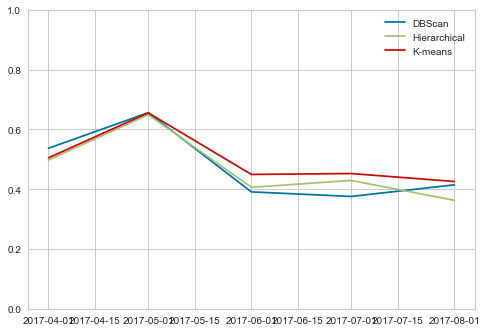

In [73]:
create_temporal_series_rand(False,  df_file_list, "", "", 6, 1)

### On retient le modèle k-means avec un nombre de clusters k = 12

-  la meillleure méthode est celle ayant la série temporelle la plus haute


## Délai des mise à jour
- après avoir trouvé le meilleur modèle, refaire le même pipeline au lieu de comparer des mois successifs, on compare les différents mois avec le premier mois

start select_dates_and_customers
2016-10-01
Period 2016-10-01 --------- 2017-4-01
is_order_number_large
2016-10-01
start get customers _ids
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')
0
2016-11-01
Period 2016-11-01 --------- 2017-5-01
is_order_number_large
2016-11-01
start get customers _ids
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')
0
2016-12-01
Period 2016-12-01 --------- 2017-6-01
is_order_number_large
2016-12-01
s

(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

C:\Users\Olfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


(1103, 5)
(99441, 8)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume'],
      dtype='obj

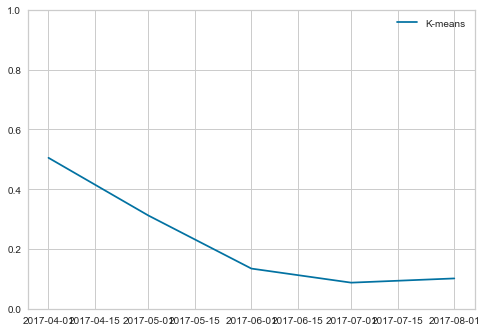

In [74]:
# reprise des étapes du pipeline en changeant date1
create_temporal_series_rand(True,  df_file_list, "", "KM", 6, 1)

- conclusion sur le délai de  mise à jour

- Maintenant nous avons le meilleur modèle, les hyperparamètres, le délai de maintenance , nous devons pouvoir interpréter les clusters pour des raisons de marketing

## Interprétation des clusters

In [75]:
final_customer_dataframe = df[features]
final_customer_dataframe=  final_customer_dataframe.fillna(0)


In [76]:
final_customer_dataframe = final_customer_dataframe.drop_duplicates()
final_customer_dataframe = final_customer_dataframe.groupby(['customer_unique_id']).sum()

sds = StandardScaler()
df_copy = pd.DataFrame()
nb_columns= final_customer_dataframe.shape[1]
df_copy= df.iloc[: , 1: nb_columns]
sds.fit(df_copy)
final_customer_dataframe_transformed = sds.transform(df_copy)


In [77]:
final_customer_dataframe.columns

Index(['Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume',
       'Recency'],
      dtype='object')

In [78]:
# calculer les centroides globaux du dataset
print(final_customer_dataframe.columns)
final_customer_dataframe_copy = final_customer_dataframe.copy() 
#final_customer_dataframe_copy = final_customer_dataframe_copy.drop('customer_unique_id', axis=1)
final_customer_dataframe_copy = final_customer_dataframe_copy.transpose()
final_customer_dataframe_copy.reset_index(drop=False, inplace=True)
final_customer_dataframe_copy["mean"] = final_customer_dataframe_copy.mean(axis=1)
print(final_customer_dataframe_copy["mean"])
sds = StandardScaler()
t = final_customer_dataframe_copy["mean"]
t = t.values.reshape(-1,1)
sds.fit(t)
df_tra = sds.transform(t)
print(df_tra)
means = df_tra.tolist()

Index(['Average_price', 'Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card',
       'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume',
       'Recency'],
      dtype='object')
0       132.735574
1       145.388596
2         1.204887
3         1.204887
4         1.065879
5         0.445787
6         0.796653
7         0.016328
8         0.208597
9         0.061677
10     2221.525718
11    18453.821974
12     1447.742558
Name: mean, dtype: float64
[[-0.32629984]
 [-0.32370453]
 [-0.35327866]
 [-0.35327866]
 [-0.35330718]
 [-0.35343437]
 [-0.3533624 ]
 [-0.35352245]
 [-0.35348302]
 [-0.35351315]
 [ 0.10214084]
 [ 3.43161655]
 [-0.05657313]]


In [79]:
# calculer les centroides des clusters
kmeans = KMeans(n_clusters=12, random_state=0).fit(final_customer_dataframe_transformed)
kmeans.labels_
kmeans.predict(final_customer_dataframe_transformed)
kmeans.cluster_centers_

array([[-2.22928925e-01, -2.36474178e-01, -1.88787772e-01,
        -1.88787772e-01, -1.68792216e-01, -5.24014670e-02,
        -1.66290203e+00, -1.27486623e-01,  1.91090290e+00,
        -1.35934712e-01, -2.10411872e-01, -2.02403592e-01],
       [-1.91458182e-01, -2.10376760e-01, -2.16007739e-01,
        -2.16007739e-01, -2.10389872e-01, -8.11996466e-01,
         3.90067192e-01, -1.27486623e-01, -4.95702730e-01,
        -8.20611752e-02, -2.66451115e-01, -2.41033646e-01],
       [ 6.56233514e-01,  2.63239887e+00,  1.16204561e+01,
         1.16204561e+01,  6.51563053e+00,  1.36614867e+00,
         2.40963992e+00, -7.28864471e-02,  1.03314718e+00,
         7.14471114e-01,  1.01138433e+00,  4.13011088e+00],
       [ 9.88486249e+00,  9.54696464e+00,  6.33841064e-02,
         6.33841064e-02,  2.31601709e-01,  2.58879402e-01,
         2.23750469e-01,  1.21379133e-03, -1.69279031e-01,
         1.30979820e-01,  1.90197271e+00,  1.24213158e+00],
       [ 3.72234302e-01,  3.44328800e-01, -1.4229865

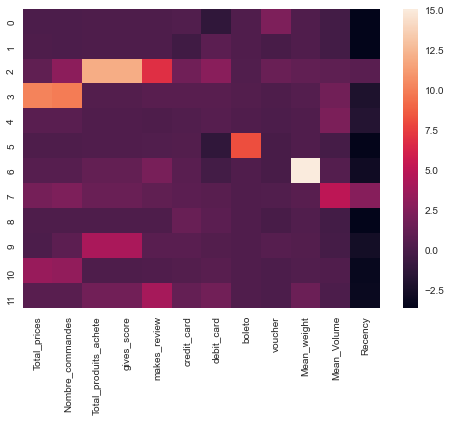

In [80]:
#matrix centroids of clusters - global centroids
for i in range (0, len (kmeans.cluster_centers_)):
    for j in range (0, len(kmeans.cluster_centers_[i])):
        kmeans.cluster_centers_[i][j] = kmeans.cluster_centers_[i][j] - means[j]
    
centroids_features = pd.DataFrame(kmeans.cluster_centers_, columns = ['Total_prices', 'Nombre_commandes',
       'Total_produits_achete', 'gives_score', 'makes_review', 'credit_card', 'debit_card', 'boleto', 'voucher', 'Mean_weight', 'Mean_Volume',
       'Recency'])
ax = sns.heatmap(centroids_features)

In [81]:
most_bought_categories = df[categories]
most_bought_categories = most_bought_categories.drop(['customer_unique_id'], axis=1)
print( most_bought_categories.columns)
max_idx = most_bought_categories.idxmax(axis = 1, skipna=True)
print(max_idx)
most_bought_categories['most_bought']= max_idx
most_bought_categories['cluster'] = kmeans.labels_
most_bought_categories.groupby('cluster')['most_bought']


Index(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories', 'health_beauty',
       'luggage_accessories', 'garden_tools', 'office_furniture', 'auto',
       'electronics', 'fashion_shoes', 'telephony', 'stationery',
       'fashion_bags_accessories', 'computers', 'home_construction',
       'watches_gifts', 'construction_tools_construction', 'pet_shop',
       'small_appliances', 'agro_industry_and_commerce',
       'furniture_living_room', 'signaling_and_security', 'air_conditioning',
       'consoles_games', 'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical', 'home_appliances_2',
  

In [82]:
most_bought_categories[['cluster', 'most_bought']].sort_values(by=['cluster'])
print(np.unique(most_bought_categories['cluster'].values))
df_ = most_bought_categories.drop_duplicates(subset=['cluster'], keep='last')
df_[['cluster', 'most_bought']]

[ 0  1  2  3  4  5  6  7  8  9 10 11]


,cluster,most_bought
92991,2,watches_gifts
93267,6,home_confort
93426,3,watches_gifts
93498,11,stationery
93504,9,perfumery
93505,4,office_furniture
93510,5,bed_bath_table
93513,0,watches_gifts
93514,10,watches_gifts
93515,7,health_beauty
